# 1. Neural Style Transfer

This section explores **neural style transfer**, a technique that leverages deep learning to merge the *content* of one image with the *style* of another—such as transforming a photograph into a painting-inspired masterpiece. We begin with a **pre-trained model**, and then pass to a **custom implementation** using the VGG19 network, where you’ll learn to manually define content and style representations through intermediate neural layers, compute Gram matrices for texture modeling, and optimize an image via gradient descent to achieve the desired blend. Along the way, we address challenges like high-frequency artifacts using total variation loss.

## Prerequisites

As is usual, let us ensure we have everything we need, and define some basic functions.

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
195196/195196 ━━━━━━━━━━━━━━━━━━━━ 1s 3us/step


## Data

Let's load and view the image we will use as content, and the image that we will use as the style. We want the content image to be modulated to match the style of the style image.

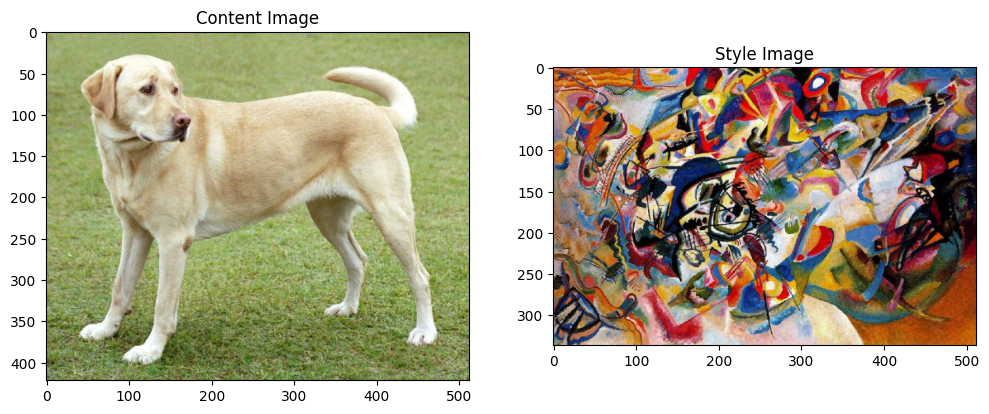

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

Let's use a pretrained model for fast style application:

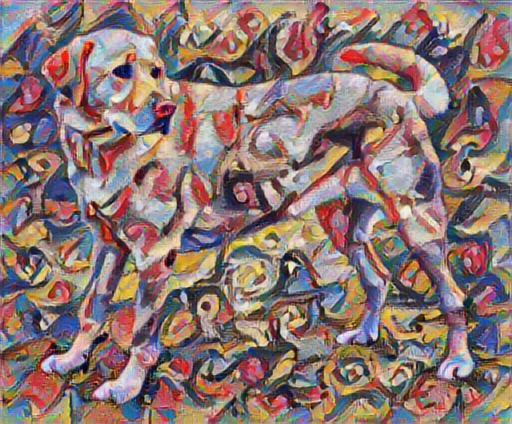

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Details
## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on our image to ensure it's used correctly:

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


[('Labrador_retriever', np.float32(0.49317148)),
 ('golden_retriever', np.float32(0.23665288)),
 ('kuvasz', np.float32(0.036357507)),
 ('Chesapeake_Bay_retriever', np.float32(0.02418274)),
 ('Greater_Swiss_Mountain_dog', np.float32(0.01864608))]

Now load a `VGG19` without the classification head, and list the layer names

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_48']
Received: inputs=Tensor(shape=(1, 336, 512, 3))
  warnings.warn(msg)


block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content
Build a model that returns the style and content tensors.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 422, 512, 3))
  warnings.warn(msg)


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.555
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.37
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

style_weight=1e-2
content_weight=1e4

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 336, 512, 3))
  warnings.warn(msg)


In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

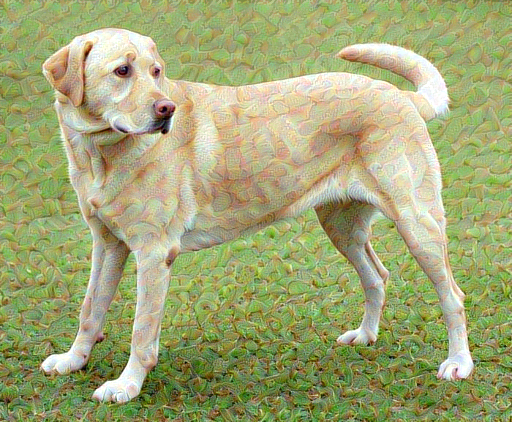

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

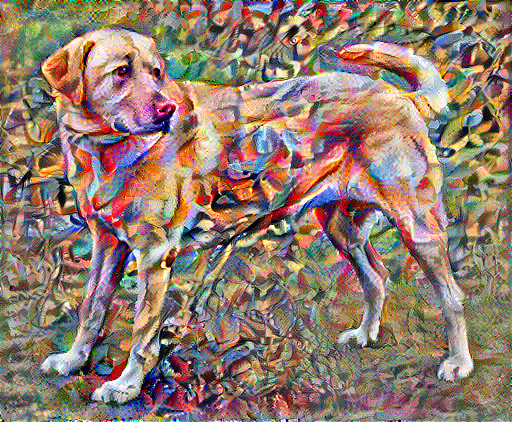

Train step: 1000
Total time: 79.8


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

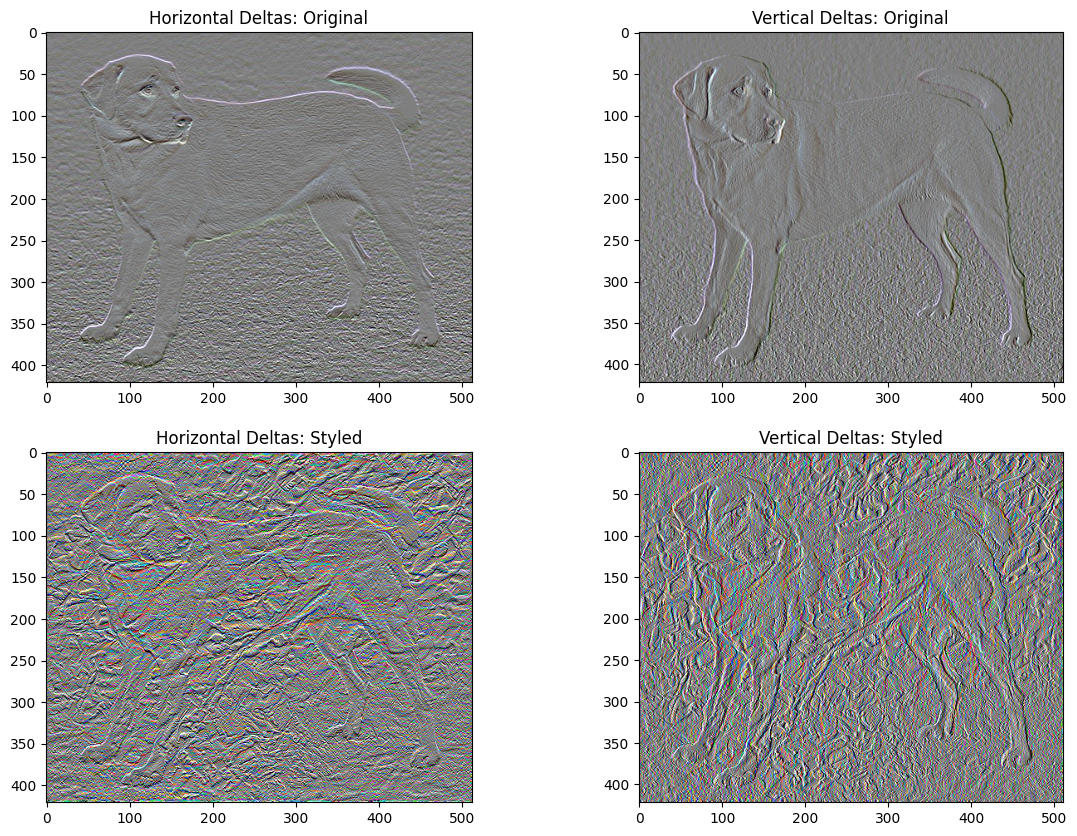

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

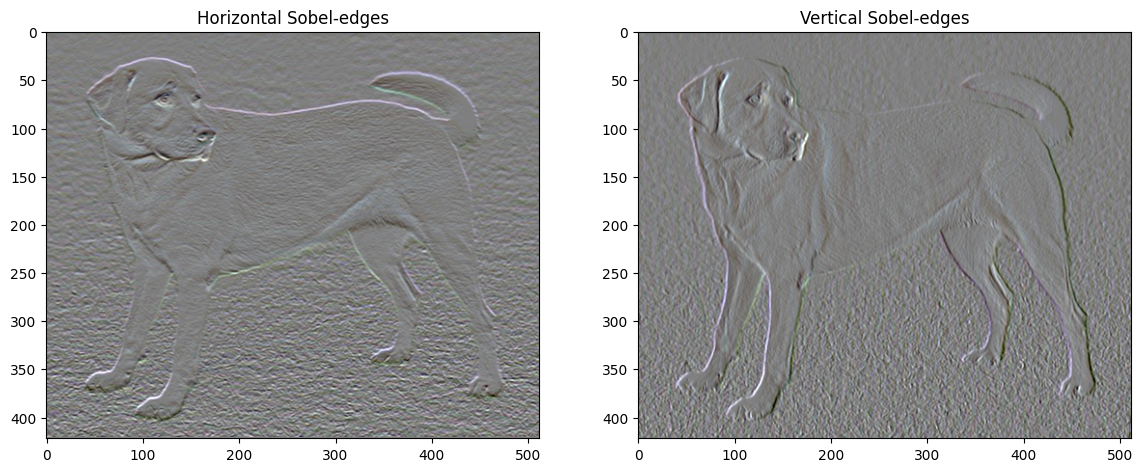

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()
tf.image.total_variation(image).numpy()

array([149248.84], dtype=float32)

## Re-run the optimization

In [ ]:
total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

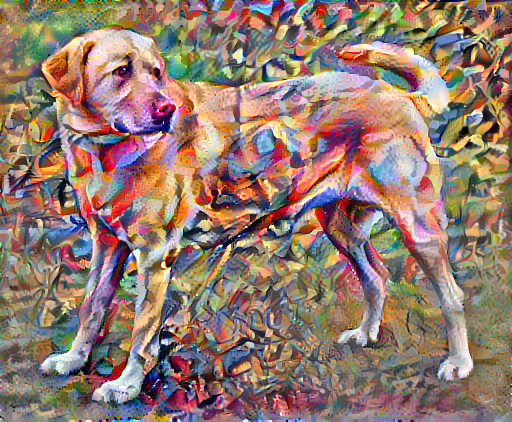

Train step: 1000
Total time: 81.5


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# 2. Finetuning Gemma 4B with QLora (Unsloth)

In [ ]:
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    # Skip restarting message in Colab
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.15.2" triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer

    # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

Ignoring six: markers 'python_version > "3.11"' don't match your environment
Ignoring setuptools: markers 'python_version > "3.11"' don't match your environment


### We are going to use Unsloth for this, they've optimised everything quite well for keeping maximum performance at limited size. Let's use a Gemma 4B, a s

In [ ]:
from unsloth import FastModel
import torch

fourbit_models = [
    # 4bit dynamic quants for superior accuracy compared with simpler quantisation methods and low memory use
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",

    # Other popular models!
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/Llama-3.3-70B",
    "unsloth/mistral-7b-instruct-v0.3",
    "unsloth/Phi-4",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-4b-it",
    max_seq_length = 2048, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # A bit more accurate, uses 2x memory
    full_finetuning = False, #
    # token = "hf_...", # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-04 21:22:47 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-04 21:22:47 [__init__.py:239] Automatically detected platform cuda.
==((====))==  Unsloth 2025.4.7: Fast Gemma3 patching. Transformers: 4.51.3. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#### QLoRA - Quantised Low-Rank Adaptation.

A LoRA comprises two matrices:

$A$ (Down-projection matrix)

Shape: $[r × k]$ (where r = rank, k = input dimension of the original weight matrix).

Initialized with random small values (often Gaussian noise). Acts as a "compressor," projecting the input into a lower-dimensional space (rank r).

$B$ (Up-projection matrix)

Shape: $[d × r]$ (where d = output dimension of the original weight matrix).

Initialized to zeros (so training starts with no initial update). Expands the low-rank representation back to the original output dimension.

The output post LoRA training will look as:

Original:   $$y = W · x$$  
LoRA-modified: $$y = W · x + (B · A) · x$$  

In QLoRA, the $W$ is quantised to 4 (or 8) bit during training, allowing for much lower memory requirements.

In [ ]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # Should leave on always!

    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.language_model.model` require gradients


<a name="Data"></a>
### Data Prep
We now use the `Gemma-3` format for conversation style finetunes. We use [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k), an instruction-following dataset in ShareGPT style. Gemma-3 renders multi turn conversations like below:

```
<bos><start_of_turn>user
Hello!<end_of_turn>
<start_of_turn>model
Hey there!<end_of_turn>
```

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, phi3, llama3, phi4, qwen2.5, gemma3` and more.

In [ ]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

In [ ]:
from datasets import load_dataset
dataset = load_dataset("mlabonne/FineTome-100k", split = "train")

We now use `standardize_data_formats` to try converting datasets to the correct format for finetuning purposes! (Without standardisation the result will be broken)

In [ ]:
from unsloth.chat_templates import standardize_data_formats
dataset = standardize_data_formats(dataset)

Visualise the first 100 rows:

In [ ]:
dataset[100]

{'conversations': [{'content': 'What is the modulus operator in programming and how can I use it to calculate the modulus of two given numbers?',
   'role': 'user'},
  {'content': 'In programming, the modulus operator is represented by the \'%\' symbol. It calculates the remainder when one number is divided by another. To calculate the modulus of two given numbers, you can use the modulus operator in the following way:\n\n```python\n# Calculate the modulus\nModulus = a % b\n\nprint("Modulus of the given numbers is: ", Modulus)\n```\n\nIn this code snippet, the variables \'a\' and \'b\' represent the two given numbers for which you want to calculate the modulus. By using the modulus operator \'%\', we calculate the remainder when \'a\' is divided by \'b\'. The result is then stored in the variable \'Modulus\'. Finally, the modulus value is printed using the \'print\' statement.\n\nFor example, if \'a\' is 10 and \'b\' is 4, the modulus calculation would be 10 % 4, which equals 2. Theref

We now have to apply the chat template for `Gemma-3` onto the conversations, and save it to `text`. We remove the `<bos>` token using removeprefix(`'<bos>'`) since we're finetuning. The Processor will add this token before training and the model expects only one.

In [ ]:
def formatting_prompts_func(examples):
   convos = examples["conversations"]
   texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False).removeprefix('<bos>') for convo in convos]
   return { "text" : texts, }

dataset = dataset.map(formatting_prompts_func, batched = True)

Let's see how the chat template did! Notice there is no `<bos>` token as the processor tokenizer will be adding one.

In [ ]:
dataset[100]["text"]

'<start_of_turn>user\nWhat is the modulus operator in programming and how can I use it to calculate the modulus of two given numbers?<end_of_turn>\n<start_of_turn>model\nIn programming, the modulus operator is represented by the \'%\' symbol. It calculates the remainder when one number is divided by another. To calculate the modulus of two given numbers, you can use the modulus operator in the following way:\n\n```python\n# Calculate the modulus\nModulus = a % b\n\nprint("Modulus of the given numbers is: ", Modulus)\n```\n\nIn this code snippet, the variables \'a\' and \'b\' represent the two given numbers for which you want to calculate the modulus. By using the modulus operator \'%\', we calculate the remainder when \'a\' is divided by \'b\'. The result is then stored in the variable \'Modulus\'. Finally, the modulus value is printed using the \'print\' statement.\n\nFor example, if \'a\' is 10 and \'b\' is 4, the modulus calculation would be 10 % 4, which equals 2. Therefore, the ou

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 30 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

In [ ]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    eval_dataset = None, # Can set up evaluation!
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 30,
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
        dataset_num_proc=2,
    ),
)

Unsloth: Switching to float32 training since model cannot work with float16


We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs. This helps increase accuracy of finetunes!

In [ ]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

Let's verify masking the instruction part is done! Let's print the 100th row again.  Notice how the sample only has a single `<bos>` as expected!

In [ ]:
tokenizer.decode(trainer.train_dataset[100]["input_ids"])

'<bos><start_of_turn>user\nWhat is the modulus operator in programming and how can I use it to calculate the modulus of two given numbers?<end_of_turn>\n<start_of_turn>model\nIn programming, the modulus operator is represented by the \'%\' symbol. It calculates the remainder when one number is divided by another. To calculate the modulus of two given numbers, you can use the modulus operator in the following way:\n\n```python\n# Calculate the modulus\nModulus = a % b\n\nprint("Modulus of the given numbers is: ", Modulus)\n```\n\nIn this code snippet, the variables \'a\' and \'b\' represent the two given numbers for which you want to calculate the modulus. By using the modulus operator \'%\', we calculate the remainder when \'a\' is divided by \'b\'. The result is then stored in the variable \'Modulus\'. Finally, the modulus value is printed using the \'print\' statement.\n\nFor example, if \'a\' is 10 and \'b\' is 4, the modulus calculation would be 10 % 4, which equals 2. Therefore, t

Now let's print the masked out example - you should see only the answer is present:

In [ ]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[100]["labels"]]).replace(tokenizer.pad_token, " ")

'                               In programming, the modulus operator is represented by the \'%\' symbol. It calculates the remainder when one number is divided by another. To calculate the modulus of two given numbers, you can use the modulus operator in the following way:\n\n```python\n# Calculate the modulus\nModulus = a % b\n\nprint("Modulus of the given numbers is: ", Modulus)\n```\n\nIn this code snippet, the variables \'a\' and \'b\' represent the two given numbers for which you want to calculate the modulus. By using the modulus operator \'%\', we calculate the remainder when \'a\' is divided by \'b\'. The result is then stored in the variable \'Modulus\'. Finally, the modulus value is printed using the \'print\' statement.\n\nFor example, if \'a\' is 10 and \'b\' is 4, the modulus calculation would be 10 % 4, which equals 2. Therefore, the output of the above code would be:\n\n```\nModulus of the given numbers is: 2\n```\n\nThis means that the modulus of 10 and 4 is 2.<end_of_t

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
5.57 GB of memory reserved.


Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 14,901,248/4,000,000,000 (0.37% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

409.2388 seconds used for training.
6.82 minutes used for training.
Peak reserved memory = 6.48 GB.
Peak reserved memory for training = 0.91 GB.
Peak reserved memory % of max memory = 43.959 %.
Peak reserved memory for training % of max memory = 6.173 %.


<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Gemma-3` team, the recommended settings for inference are `temperature = 1.0, top_p = 0.95, top_k = 64` (With a fully trained LoRA, you could run it with your own inference engine of choice)

In [ ]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)
messages = [{
    "role": "user",
    "content": [{
        "type" : "text",
        "text" : "Continue the sequence: 1, 1, 2, 3, 5, 8,",
    }]
}]
text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
)
outputs = model.generate(
    **tokenizer([text], return_tensors = "pt").to("cuda"),
    max_new_tokens = 64, # Increase for longer outputs!
    # Recommended Gemma-3 settings!
    temperature = 1.0, top_p = 0.95, top_k = 64,
)
tokenizer.batch_decode(outputs)

['<bos><start_of_turn>user\nContinue the sequence: 1, 1, 2, 3, 5, 8,<end_of_turn>\n<start_of_turn>model\nThe sequence is the Fibonacci sequence, which is generated by the following steps: the first two terms are 1 and 1. The next term is the sum of the two previous terms: 1+1=2, 1+2=3, 2+3=5, 3+5=']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
messages = [{
    "role": "user",
    "content": [{"type" : "text", "text" : "Why is the sky blue?",}]
}]
text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer([text], return_tensors = "pt").to("cuda"),
    max_new_tokens = 64, # Increase for longer outputs!
    # Recommended Gemma-3 settings!
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

The sky is blue because of a phenomenon called Rayleigh scattering, which is the scattering of electromagnetic radiation by particles of a much smaller wavelength than the radiation itself. As sunlight enters the Earth’s atmosphere, it collides with tiny air molecules, causing them to scatter in different directions. This scattering is more effective with shorter wavelengths


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("gemma-3")  # Local saving
tokenizer.save_pretrained("gemma-3")
# model.push_to_hub("HF_ACCOUNT/gemma-3", token = "...") # Online saving
# tokenizer.push_to_hub("HF_ACCOUNT/gemma-3", token = "...") # Online saving

['gemma-3/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastModel
    model, tokenizer = FastModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        load_in_4bit = True,
    )

messages = [{
    "role": "user",
    "content": [{"type" : "text", "text" : "What is Gemma-3?",}]
}]
text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer([text], return_tensors = "pt").to("cuda"),
    max_new_tokens = 64, # Increase for longer outputs!
    # Recommended Gemma-3 settings!
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

Gemma is a family of open-weight language models developed by the team at DeepMind. These models come in various sizes, with the Gemma-3 being the newest and most capable of the family. 
Gemma-3 is available in different sizes, from 2B to 7B parameters, each


### Saving to float16 for VLLM

VLLM is rather good for deployment, but it needs the model in FP16. We save it in the folder `gemma-3-finetune`. Set `if False` to `if True` to let it run.

In [ ]:
if False: # Change to True to save finetune!
    model.save_pretrained_merged("gemma-3-finetune", tokenizer)

If you want to upload / push to your Hugging Face account, set `if False` to `if True` and add your Hugging Face token and upload location!

In [ ]:
if False: # Change to True to upload finetune
    model.push_to_hub_merged(
        "HF_ACCOUNT/gemma-3-finetune", tokenizer,
        token = "hf_..."
    )

### GGUF / llama.cpp Conversion
GGUF is a very convenient format for local running, since it allows splitting model layers between the CPU and the GPU(s). Very comfortable if you want to run it on your home PC. To save to `GGUF` / `llama.cpp`. Unsloth supports `Q8_0, F16 or BF16` precision at this point.

In [ ]:
if False: # Change to True to save to GGUF
    model.save_pretrained_gguf(
        "gemma-3-finetune",
        quantization_type = "Q8_0", # For now only Q8_0, BF16, F16 supported
    )

Now, use the `gemma-3-finetune.gguf` file or `gemma-3-finetune-Q4_K_M.gguf` file in llama, which you can build with a simple server, or use a frontend such as Open WebUI. You can install llama.cpp [here](https://github.com/ggml-org/llama.cpp) and Open WebUI [here](https://github.com/open-webui/open-webui).

# 3 Disco Diffusion
We highly recommend you to try Disco Diffusion (it is fun): https://colab.research.google.com/github/alembics/disco-diffusion/blob/main/Disco_Diffusion.ipynb. In the notebook you will be able to try out text to image, image to image and video generation.  You will be able to try out various CLIP versions and diffusion models, and assess consistency through optical flow.